## Gathering BGG Data

This notebook gives the web scraping pipeline to get data for each board game on BGG

In [1]:
import requests, bs4
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import time, os
import ast
import matplotlib.pyplot as plt

import statsmodels.api as sm
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from scipy import stats
import pickle

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [103]:
#url = "https://boardgamegeek.com/boardgame/586/front/stats"

#response = requests.get(url)
#status = response.status_code
#if status == 200:
#  page = response.text
#  soup = bs(page)
#else:
#  print(f"Oops! Received status code {status}")

In [153]:
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

driver = webdriver.Chrome(chromedriver)

<ipython-input-153-3ed8d520c4d8>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(chromedriver)


## Stats Page

We'll begin by exploring the stats page for one game. From here, we should be able to get

* Number owned
* Average rating
* Weight
* Recommended age
* Min, max estimated time
* Min, max player count
* Community min, max and best player counts

Other features to consider:

* \# of ratings
* Std deviation of ratings
* \# of comments
* \# of plays
* \# of fans
* \# of page views
* Prev. owned
* Wishlist

In [105]:

driver.get("https://boardgamegeek.com/boardgame/122691/magnum-opus/stats")

soup = bs(driver.page_source,'html5lib')

In [106]:
soup.find_all(href=re.compile("status=own"))[0].text

'316'

In [107]:
soup.find(text=re.compile("Avg. Rating")).next.next.text.strip()

'6.967'

In [9]:
def get_num_owned(soup):
    try:
        num_str = soup.find(href=re.compile("status=own")).text
        num = int(num_str.replace(",",""))
        return num
    except:
        return None

In [109]:
get_num_owned(soup)

316

In [10]:
def get_rating(soup):
    try:
        return float(soup.find(text=re.compile("Avg. Rating")).next.next.text.strip())
    except:
        return None

In [111]:
get_rating(soup)

6.967

### Gameplay items

The gameplay item class contains 4 relevant pieces of information for us.

* Player count
* Play time
* Player age
* Weight

In [112]:
gameplay_list = soup.find_all(class_="gameplay-item")

print([x.text for x in gameplay_list])

[' \t\t\t\t \t\t\t\t\t     2–4  \t\t\t\t\tPlayers \t\t\t\t \t\t\t\t \t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t\t\tCommunity: \t\t\t\t\t\t\t \t\t\t\t\t\t\t\t(no votes) \t\t\t\t\t\t\t \t\t\t\t\t\t\t \t\t\t\t\t\t\t\t3–4 \t\t\t\t\t\t\t \t\t\t\t\t\t\t \t\t\t\t\t\t\t\t— \t\t\t\t\t\t\t\tBest: 4 \t\t\t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t \t\t\t\t \t\t\t', ' \t\t\t\t \t\t\t\t\t \t\t\t\t\t \t\t\t\t\t\t     60  Min \t\t\t\t\t \t\t\t\t \t\t\t\t \t\t\t\t\t \t\t\t\t\t\tPlaying Time \t\t\t\t\t \t\t\t\t\t \t\t\t\t \t\t\t', ' \t\t\t\t \t\t\t\t\tAge: \t\t\t\t\t \t\t\t\t\t \t\t\t\t\t\t12+ \t\t\t\t\t \t\t\t\t \t\t\t\t \t\t\t\t\t \t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t\t\tCommunity: 12+ \t\t\t\t\t\t \t\t\t\t\t \t\t\t\t \t\t\t', " \t\t\t\t \t\t\t\t\tWeight: \t\t\t\t\t \t\t\t\t\t\t–– \t\t\t\t\t \t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t\t\t2.54 \t\t\t\t\t\t \t\t\t\t\t\t/ 5 Complexity Rating \t\t\t\t\t  \t\t\t\t \t\t\t\t \t\t\t\t\t \t\t\t\t\t\t \t\t\t\t\t\t\t'Complexity' Rating Results \t\t\t\t\t\t \t\t\t\t\t  \t\t\t\t\t \t\t\t\t\t\t

Game weight and player age are fairly straight forward

In [113]:
float(gameplay_list[3].find(text=re.compile("/ 5")).previous.strip())

2.54

In [11]:
def get_weight(soup):
    try:
        gameplay_list = soup.find_all(class_="gameplay-item")

        return float(gameplay_list[3].find(text=re.compile("/ 5")).previous.strip())
    
    except:
        return None

In [115]:
get_weight(soup)

2.54

In [12]:
#Fix this, so not dependant on +
def get_age(soup):
    try:
        gameplay_list = soup.find_all(class_="gameplay-item")
        return int(gameplay_list[2].find(text=re.compile("\+")).strip().replace("+",""))
    except:
        return None

In [117]:
x = get_age(soup)

In [118]:
print(x)

12


Note this is only the age "on the box". There is also a community recommended age, which I am not scraping at this time. (Something to look at later)

Play time and player counts are trickier. The way the html is structured changes based on if the minimum and maximum values are the same. For example the player count may appear as 

2 Players

OR

2 - 6 Players

So we have to deal with those cases here.

In [28]:
gameplay_list[1].find_all(class_=re.compile("ng-binding ng-scope"))

[<span class="ng-binding ng-scope" ng-if="min &gt; 0">60</span>]

In [13]:
def get_minmax_time(soup):
    try:
        gameplay_list = soup.find_all(class_="gameplay-item")
        time_values = gameplay_list[1].find_all(class_=re.compile("ng-binding ng-scope"))
        if len(time_values) == 3:
            return int(time_values[0].text), int(time_values[1].text.replace("–",""))
        else:
            #If only one value, same min and max time
            value = int(time_values[0].text)
            return value,value
    except:
        return None, None

In [30]:
get_minmax_time(soup)

(60, 60)

In [31]:
gameplay_list[0].find_all(class_=re.compile("ng-binding ng-scope"))

[<span class="ng-binding ng-scope" ng-if="min &gt; 0">2</span>,
 <span class="ng-binding ng-scope" ng-if="max&gt;0 &amp;&amp; min != max"><!-- ngIf: min>0 --><span class="ng-binding ng-scope" ng-if="min&gt;0">–</span><!-- end ngIf: min>0 -->3</span>,
 <span class="ng-binding ng-scope" ng-if="min&gt;0">–</span>]

In [14]:
def get_minmax_players(soup):
    try:
        gameplay_list = soup.find_all(class_="gameplay-item")
        players_values = gameplay_list[0].find_all(class_=re.compile("ng-binding ng-scope"))
        if len(players_values) == 3:
            return int(players_values[0].text), int(players_values[1].text.replace("–",""))
        else:
            #If only one player count, min and max are the same
            value = int(players_values[0].text)
            return value, value
    except:
        return None, None
    


In [33]:
get_minmax_players(soup)

(2, 3)

There is also community recommended number of players (a min, max and best count). This is again something to look at later.

## Credits Page

Like we did for the stats page, we'll now try to collect the data for one credits page. Features we are looking to scrape are:

* Designer(s)
* Publisher(s)
* Categories
* Mechanisms

The should all be fairly similar, but note that each of these may have more than one entry. A slight challenge to account for.

In [92]:

driver.get("https://boardgamegeek.com/boardgame/122691/magnum-opus/credits")

soup = bs(driver.page_source,'html5lib')

In [15]:
def get_publishers(soup):
    try:
        pubs = soup.find(attrs={"name":"boardgamepublisher"}).find_next("div").find_all("a")
        pubs = [x.text.strip() for x in pubs]
        return pubs
    except:
        return None


In [94]:
get_publishers(soup)

['Clever Mojo Games', 'Game Salute']

In [16]:
def get_designers(soup):
    try:
        designers = soup.find(attrs={"name":"boardgamedesigner"}).find_next("div").find_all("a")
        designers = [x.text.strip() for x in designers]
        return designers
    except:
        return None

In [96]:
get_designers(soup)

['Ian Stedman']

In [17]:
def get_categories(soup):
    try:
        cats = soup.find(attrs={"name":"boardgamecategory"}).find_next("div").find_all("a")
        cats = [x.text.strip() for x in cats]
        return cats
    except:
        return None

In [98]:
get_categories(soup)

['Card Game', 'Fantasy', 'Medieval', 'Mythology']

In [18]:
def get_mechanics(soup):
    try:
        mechs = soup.find(attrs={"name":"boardgamemechanic"}).find_next("div").find_all("a")
        mechs = [x.text.strip() for x in mechs]
        return mechs
    except:
        return None

In [244]:
get_mechanics(soup)

## URL Collections

Now let's collect the name, url, and year for all the games.

We'll start by creating an empty dataframe to fill in with the information as we get it.

In [177]:
column_names = ["name","url","year", "num_owned", "rating", "weight", "player_age", "min_players","max_players",
               "min_time","max_time","designers","publishers","categories","mechanics"]

df = pd.DataFrame(columns = column_names)

df

,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics


In [178]:
import time

base_url = "https://boardgamegeek.com/browse/boardgame/page/"
start = 1
stop = 214

for i in range(start, stop+1):
    if  (i - start) % 10 == 2:
        print((i-start)/(stop-start)*100, "% pages read,", (i-start), "in total")
        df.to_csv("games.csv", index=False)
    url = base_url + str(i)
    driver.get(url)
    soup = bs(driver.page_source,'html5lib')
    rows = []
    for x in soup.find_all("div", attrs={"id":re.compile("results_objectname")}):
        try:
            game_url = x.find("a")["href"]
        except:
            game_url = None
        try:
            game_name = x.find("a").text
        except:
            game_name = None
        try:
            game_year = int(x.find(class_="smallerfont dull").text.replace("(","").replace(")",""))
        except:
            game_year = None
        rows.append([game_name,game_url, game_year])
    df_temp = pd.DataFrame(rows, columns = ["name","url","year"])
    df = pd.concat([df,df_temp])
    time.sleep(5)

df.to_csv("games.csv", index=False)

0.9389671361502347 % pages read, 2 in total
5.633802816901409 % pages read, 12 in total
10.328638497652582 % pages read, 22 in total
15.023474178403756 % pages read, 32 in total
19.718309859154928 % pages read, 42 in total
24.413145539906104 % pages read, 52 in total
29.107981220657276 % pages read, 62 in total
33.80281690140845 % pages read, 72 in total
38.497652582159624 % pages read, 82 in total
43.1924882629108 % pages read, 92 in total
47.88732394366197 % pages read, 102 in total
52.58215962441315 % pages read, 112 in total
57.27699530516433 % pages read, 122 in total
61.97183098591549 % pages read, 132 in total
66.66666666666666 % pages read, 142 in total
71.36150234741784 % pages read, 152 in total
76.05633802816901 % pages read, 162 in total
80.75117370892019 % pages read, 172 in total
85.44600938967136 % pages read, 182 in total
90.14084507042254 % pages read, 192 in total
94.83568075117371 % pages read, 202 in total
99.53051643192488 % pages read, 212 in total


,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics
0,Gloomhaven,/boardgame/174430/gloomhaven,2017,None,None,None,None,None,None,None,None,None,None,None,None
1,Pandemic Legacy: Season 1,/boardgame/161936/pandemic-legacy-season-1,2015,None,None,None,None,None,None,None,None,None,None,None,None
2,Brass: Birmingham,/boardgame/224517/brass-birmingham,2018,None,None,None,None,None,None,None,None,None,None,None,None
3,Terraforming Mars,/boardgame/167791/terraforming-mars,2016,None,None,None,None,None,None,None,None,None,None,None,None
4,Gloomhaven: Jaws of the Lion,/boardgame/291457/gloomhaven-jaws-lion,2020,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Labyrinth,/boardgame/6546/labyrinth,1940.0,None,None,None,None,None,None,None,None,None,None,None,None
96,Dirty Minds: The Game of Naughty Clues,/boardgame/2956/dirty-minds-game-naughty-clues,1990.0,None,None,None,None,None,None,None,None,None,None,None,None
97,MindTrap,/boardgame/1923/mindtrap,1991.0,None,None,None,None,None,None,None,None,None,None,None,None
98,Phase 10,/boardgame/1258/phase-10,1982.0,None,None,None,None,None,None,None,None,None,None,None,None


In [246]:
df2 = df.sample(frac=1)
df2.reset_index(inplace=True,drop=True)
df2.head()

,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics
0,The Piggyback Brigade,/boardgame/1806/piggyback-brigade,2000,None,None,None,None,None,None,None,None,None,None,None,None
1,Skräll,/boardgame/31421/skrall,2007.0,None,None,None,None,None,None,None,None,None,None,None,None
2,Descent on Crete: May 1941,/boardgame/5860/descent-crete-may-1941,1978.0,None,None,None,None,None,None,None,None,None,None,None,None
3,Castro,/boardgame/149863/castro,2013,None,None,None,None,None,None,None,None,None,None,None,None
4,1655: Habemus Papam,/boardgame/82955/1655-habemus-papam,2010,None,None,None,None,None,None,None,None,None,None,None,None


df.dtypes

Now let's scrape all the pages

In [19]:
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

driver = webdriver.Chrome(chromedriver)

df2 = pickle.load(open("df2.p","rb"))

for ind in df2.index:
    #Check if we've seen this row already
    if df2.iloc[ind].notna().sum() > 3:
        continue
        
    
    if ind % 20 == 0:
        print(ind, "games scraped", ind/df2.shape[0]*100, "%")
        df2.to_csv("games2.csv", index=False)
        pickle.dump(df2, open("df2.p","wb"))
        
        
    url = "https://boardgamegeek.com/" + df2.iloc[ind].url
    
    driver.get(url + "/stats")
    stats_soup = bs(driver.page_source,'html5lib')
    
    df2.iloc[ind].num_owned = get_num_owned(stats_soup)
    df2.iloc[ind].rating = get_rating(stats_soup)
    df2.iloc[ind].weight = get_weight(stats_soup)
    df2.iloc[ind].player_age = get_age(stats_soup)
    df2.iloc[ind].min_time,df2.iloc[ind].max_time= get_minmax_time(stats_soup)
    df2.iloc[ind].min_players,df2.iloc[ind].max_players= get_minmax_players(stats_soup)
    
    time.sleep(5)
    
    driver.get(url + "/credits")
    credits_soup = bs(driver.page_source,'html5lib')
    
    df2.iloc[ind].designers = get_designers(credits_soup)
    df2.iloc[ind].publishers = get_publishers(credits_soup)
    df2.iloc[ind].categories = get_categories(credits_soup)
    df2.iloc[ind].mechanics = get_mechanics(credits_soup)
    
    
    
    time.sleep(5)
    

df2.to_csv("games2.csv", index=False)
pickle.dump(df2, open("df2.p","wb"))  
    

<ipython-input-19-dbdefea6d783>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(chromedriver)


21380 games scraped 99.90654205607477 %


/Users/rsolava/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [2]:
#Read in df2 from csv or pickle
#def string_to_list(x):
#    try:
#        return ast.literal_eval(x)
#    except:
#        return None
#df2 = pd.read_csv("games2.csv")

#df2.publishers = df2.publishers.apply(string_to_list)    
#df2.categories = df2.categories.apply(string_to_list)    
#df2.designers = df2.designers.apply(string_to_list)    
#df2.mechanics = df2.mechanics.apply(string_to_list)

df2 = pickle.load(open("df2.p","rb"))

In [3]:
df2.head()

,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics
0,The Piggyback Brigade,/boardgame/1806/piggyback-brigade,2000.0,679.0,6.101,1.05,4.0,2.0,7.0,15.0,25.0,[Alex Randolph],"[Devir, Drei Magier Spiele, G3, Korea Boardgam...","[Action / Dexterity, Children's Game, Dice, Ra...",[Dice Rolling]
1,Skräll,/boardgame/31421/skrall,2007.0,75.0,5.709,1.75,NaN,2.0,6.0,60.0,60.0,"[Anthony Pendleton, Paul Smith]",[Strategic Retreat],"[Science Fiction, Space Exploration, Wargame]","[Dice Rolling, Modular Board, Variable Player ..."
2,Descent on Crete: May 1941,/boardgame/5860/descent-crete-may-1941,1978.0,249.0,5.961,3.91,14.0,2.0,2.0,240.0,240.0,[Eric Goldberg],"[SPI (Simulations Publications, Inc.)]","[Wargame, World War II]","[Dice Rolling, Hexagon Grid, Simulation]"
3,Castro,/boardgame/149863/castro,2013.0,287.0,6.515,1.41,8.0,2.0,4.0,20.0,20.0,[Jürgen P. Grunau],[Noris Spiele],[Dice],"[Dice Rolling, Pattern Building, Push Your Luck]"
4,1655: Habemus Papam,/boardgame/82955/1655-habemus-papam,2010.0,738.0,6.453,2.16,10.0,3.0,4.0,30.0,30.0,[Christoph Bauer],"[999 Games, DDD Verlag GmbH]","[Card Game, Pike and Shot, Religious]","[Auction/Bidding, Set Collection]"


In [4]:
game_df = df2[df2.num_owned.notna()]
game_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21379 entries, 0 to 21379
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         21379 non-null  object 
 1   url          21379 non-null  object 
 2   year         21195 non-null  float64
 3   num_owned    21379 non-null  float64
 4   rating       21377 non-null  float64
 5   weight       21379 non-null  float64
 6   player_age   20951 non-null  float64
 7   min_players  21345 non-null  float64
 8   max_players  21345 non-null  float64
 9   min_time     20763 non-null  float64
 10  max_time     20763 non-null  float64
 11  designers    21369 non-null  object 
 12  publishers   21369 non-null  object 
 13  categories   21369 non-null  object 
 14  mechanics    21369 non-null  object 
dtypes: float64(9), object(6)
memory usage: 2.6+ MB


In [91]:
game_df.loc[:,"num_owned"] = game_df.num_owned.astype(int, errors="ignore")

/Users/rsolava/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [92]:
game_df.loc[:,"rating"] = game_df.rating.astype(float, errors="ignore")
game_df.loc[:,"year"] = game_df.year.astype(float,errors="ignore")
game_df.loc[:,"weight"] = game_df.weight.astype(float, errors="ignore")
game_df.loc[:,"player_age"] = game_df.player_age.astype(float, errors="ignore")
game_df.loc[:,"min_players"] = game_df.min_players.astype(float, errors="ignore")
game_df.loc[:,"max_players"] = game_df.max_players.astype(float, errors="ignore")
game_df.loc[:,"min_time"] = game_df.min_time.astype(float, errors="ignore")
game_df.loc[:,"max_time"] = game_df.max_time.astype(float, errors="ignore")

In [93]:
game_df.dtypes

name            object
url             object
year           float64
num_owned        int64
rating         float64
weight         float64
player_age     float64
min_players    float64
max_players    float64
min_time       float64
max_time       float64
designers       object
publishers      object
categories      object
mechanics       object
dtype: object

In [5]:
game_df.loc[:,"log_owned"] = np.log10(game_df.num_owned)

/Users/rsolava/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/rsolava/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Dealing with missing data

In [6]:
for col in game_df.select_dtypes(include=np.number).columns:
    print(col, "missing: {}, mean: {}, median: {}".format(
        game_df[col].isna().sum(), game_df[col].mean(), game_df[col].median()))

year missing: 184, mean: 2003.4703467799009, median: 2011.0
num_owned missing: 0, mean: 1448.448664577389, median: 313.0
rating missing: 2, mean: 6.421054076811534, median: 6.446
weight missing: 0, mean: 1.9855779035502084, median: 1.97
player_age missing: 428, mean: 10.292682926829269, median: 10.0
min_players missing: 34, mean: 2.014523307566175, median: 2.0
max_players missing: 34, mean: 5.688779573670649, median: 4.0
min_time missing: 616, mean: 66.01001782016087, median: 30.0
max_time missing: 616, mean: 93.40148340798535, median: 45.0
log_owned missing: 0, mean: 2.600123341696565, median: 2.4955443375464483


We'll impute all missing values with the median.

For each feature, either the mean and median seem very close, or the mean is highly effected by outliers

In [7]:
for col in game_df.select_dtypes(include=np.number).columns:
    game_df[col] = game_df[col].fillna(value=game_df[col].median())

<ipython-input-7-822852be40f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df[col] = game_df[col].fillna(value=game_df[col].median())


In [10]:
game_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21379 entries, 0 to 21379
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         21379 non-null  object 
 1   url          21379 non-null  object 
 2   year         21379 non-null  float64
 3   num_owned    21379 non-null  float64
 4   rating       21379 non-null  float64
 5   weight       21379 non-null  float64
 6   player_age   21379 non-null  float64
 7   min_players  21379 non-null  float64
 8   max_players  21379 non-null  float64
 9   min_time     21379 non-null  float64
 10  max_time     21379 non-null  float64
 11  designers    21369 non-null  object 
 12  publishers   21369 non-null  object 
 13  categories   21369 non-null  object 
 14  mechanics    21369 non-null  object 
 15  log_owned    21379 non-null  float64
dtypes: float64(10), object(6)
memory usage: 2.8+ MB


## Remove outliers in year

We want to remove all 2020 and later games, since these games may not be released yet or have been out for a much shorter time.

We'll also remove all games from before 1980.

In [8]:
Q1 = game_df.year.quantile(0.25)
Q3 = game_df.year.quantile(0.75)
IQR = Q3-Q1

print(Q1-1.5*IQR,Q3+1.5*IQR)

1979.5 2039.5


In [9]:
game_df = game_df[(game_df.year < 2020) & (game_df.year >=1980)]

game_df.shape

(18678, 16)

Remove outliers in terms of log_owned

In [68]:
Q1 = game_df.log_owned.quantile(0.25)
Q3 = game_df.log_owned.quantile(0.75)
IQR = Q3-Q1


game_df = game_df[~((game_df.log_owned < (Q1 - 1.5 * IQR)) |(game_df.log_owned > (Q3 + 1.5 * IQR)))]


In [10]:
game_df.shape

(18678, 16)

In [70]:
#game_df = game_df.dropna()
#game_df.shape

In [11]:
X =game_df.drop(columns =["name","url","rating","num_owned","designers","publishers","categories","mechanics","log_owned"])
X["weight_sq"] = X.weight*X.weight
X["avg_time"] = (X.min_time + X.max_time)/2
X = X.drop(columns=["min_time","max_time"])
X["avg_players"] = (X.min_players + X.max_players)/2
X = X.drop(columns=["min_players","max_players"])
y = game_df.num_owned
X = sm.add_constant(X)

model = sm.OLS(np.log(y),X)
game_model = model.fit()

game_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_owned   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     274.8
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:28:16   Log-Likelihood:                -31843.
No. Observations:               18678   AIC:                         6.370e+04
Df Residuals:                   18671   BIC:                         6.375e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -23.9607      2.022    -11.850      0.000     -27.924     -19.997
year            0.0141      0.001     14.038      0.000       0.012       0.016
weight          0.9284      0.046     20.265      0.000       0.839       1.018
player_age      0.0375      0.004      9.422      0.000       0.030       0.045
weight_sq      -0.1343      0.010    -13.029      0.000      -0.154      -0.114
avg_time    -3.337e-05   4.56e-05     -0.731      0.465      -0.000    5.61e-05
avg_players     0.0030      0.001      2.386      0.017       0.001       0.005
==============================================================================
Omnibus:                     1641.101   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2222.362
Skew:                           0.736   Prob(JB):                         0.00
Kurtosis:                       3.828   Cond. No.                     4.17e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

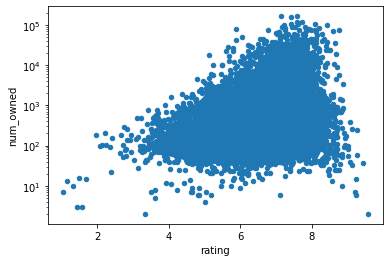

In [12]:
x = np.arange(0, 6)

# scatter-plot data
ax = game_df.plot(x='rating', y='num_owned', kind='scatter',logy=True)

# plot regression line on the same axes, set x-axis limits
#ax.plot(x, np.exp(game_model.params.const + game_model.params.weight * x), color = "red")

#plt.savefig("weight_reg.png", bbox_inches="tight")

In [13]:
game_model.params

const         -23.960716
year            0.014125
weight          0.928388
player_age      0.037509
weight_sq      -0.134270
avg_time       -0.000033
avg_players     0.002951
dtype: float64

In [17]:
y = game_df.log_owned
X = game_df.drop(columns =["name","url","rating","num_owned","designers","publishers","categories","mechanics","log_owned"])

X, X_test, y, y_test = train_test_split(X,y, test_size=0.3)

reg_tree = RandomForestRegressor(max_depth=25)
reg_tree.fit(X, y)


RandomForestRegressor(max_depth=25)

In [18]:
reg_tree.feature_importances_

array([0.17904096, 0.41098997, 0.09746151, 0.04117842, 0.09616024,
       0.08312252, 0.09204639])

In [19]:
reg_tree.score(X_test,y_test)

0.2990270117788939

In [75]:
game_df.head()

,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics,log_owned
0,The Piggyback Brigade,/boardgame/1806/piggyback-brigade,2000.0,679,6.101,1.05,4.0,2.0,7.0,15.0,25.0,[Alex Randolph],"[Devir, Drei Magier Spiele, G3, Korea Boardgam...","[Action / Dexterity, Children's Game, Dice, Ra...",[Dice Rolling],2.831870
1,Skräll,/boardgame/31421/skrall,2007.0,75,5.709,1.75,10.0,2.0,6.0,60.0,60.0,"[Anthony Pendleton, Paul Smith]",[Strategic Retreat],"[Science Fiction, Space Exploration, Wargame]","[Dice Rolling, Modular Board, Variable Player ...",1.875061
3,Castro,/boardgame/149863/castro,2013.0,287,6.515,1.41,8.0,2.0,4.0,20.0,20.0,[Jürgen P. Grunau],[Noris Spiele],[Dice],"[Dice Rolling, Pattern Building, Push Your Luck]",2.457882
4,1655: Habemus Papam,/boardgame/82955/1655-habemus-papam,2010.0,738,6.453,2.16,10.0,3.0,4.0,30.0,30.0,[Christoph Bauer],"[999 Games, DDD Verlag GmbH]","[Card Game, Pike and Shot, Religious]","[Auction/Bidding, Set Collection]",2.868056
5,Kreus,/boardgame/198110/kreus,2016.0,826,6.696,2.00,10.0,3.0,6.0,20.0,30.0,[Julien Prothière],"[2Tomatoes Games, CMON Global Limited, Sweet G...","[Card Game, Deduction, Mythology]","[Communication Limits, Cooperative Game]",2.916980


## Are games sold and number owned correlated?

We're using number of users who own the game as a proxy for number of games sold, since unfortunately the number of games sold is just not public information. It seems reasonable that these things would be correlated, but are they really? Luckily, one publisher did share their sales data, so we'll use this limited information to see if this assumption is correct.

In [20]:
num_sold = [["Twilight Struggle", 100000], ["Battle Line",40000],["Dominant Species",25000],
            ["Commands & Colors: Ancients", 20000],["Paths of Glory",16000],["Combat Commander: Europe",13000],
            ["Wilderness War",11000], ["Labyrinth: The War on Terror, 2001 – ?",11000],
            ["Thunder Alley", 9500], ["Formula Motor Racing",9000], ["Ivanhoe",9000],
            ["Commands & Colors: Napoleonics",9000], ["Washington's War", 9000],["Here I Stand", 8500]]

num_sold_df = pd.DataFrame(num_sold, columns = ["name","num_sold"])

In [21]:
game_df[(game_df.name == "Washington's War")]

,name,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics,log_owned
15694,Washington's War,/boardgame/38996/washingtons-war,2010.0,4499.0,7.636,2.84,12.0,2.0,2.0,90.0,90.0,[Mark Herman],"[GMT Games, Spielworxx]","[Age of Reason, American Revolutionary War, Wa...","[Area Majority / Influence, Campaign / Battle ...",3.653116


In [22]:
gt_df = num_sold_df.set_index("name").join(game_df.set_index("name"))
gt_df

,num_sold,url,year,num_owned,rating,weight,player_age,min_players,max_players,min_time,max_time,designers,publishers,categories,mechanics,log_owned
name,,,,,,,,,,,,,,,,
Battle Line,40000,/boardgame/760/battle-line,2000.0,19632.0,7.414,1.90,12.0,2.0,2.0,30.0,30.0,[Reiner Knizia],"[GMT Games, Chrononauts Games, Lavka Games, Ne...","[Ancient, Card Game, Deduction]","[Card Play Conflict Resolution, Hand Managemen...",4.292965
Combat Commander: Europe,13000,/boardgame/21050/combat-commander-europe,2006.0,8296.0,7.946,3.25,12.0,2.0,2.0,60.0,180.0,[Chad Jensen],"[GMT Games, Devir]","[Wargame, World War II]","[Advantage Token, Campaign / Battle Card Drive...",3.918869
Commands & Colors: Ancients,20000,/boardgame/14105/commands-colors-ancients,2006.0,10626.0,7.776,2.69,12.0,2.0,2.0,60.0,60.0,[Richard Borg],"[GMT Games, Wargames Club Publishing]","[Ancient, Wargame]","[Campaign / Battle Card Driven, Command Cards,...",4.026370
Commands & Colors: Napoleonics,9000,/boardgame/62222/commands-colors-napoleonics,2010.0,5073.0,8.009,2.74,14.0,2.0,2.0,90.0,90.0,[Richard Borg],[GMT Games],"[Napoleonic, Wargame]","[Campaign / Battle Card Driven, Command Cards,...",3.705265
Dominant Species,25000,/boardgame/62219/dominant-species,2010.0,20123.0,7.841,4.04,14.0,2.0,6.0,120.0,240.0,[Chad Jensen],"[GMT Games, Asmodee, Asterion Press, Filosofia...","[Animals, Environmental, Prehistoric]","[Action Queue, Area Majority / Influence, Card...",4.303693
Formula Motor Racing,9000,/boardgame/635/formula-motor-racing,1995.0,2320.0,6.408,1.18,8.0,3.0,6.0,20.0,20.0,[Reiner Knizia],"[Egmont Polska, Gibsons, GMT Games, Die Spiege...","[Card Game, Racing, Sports]","[Dice Rolling, Hand Management, Relative Movem...",3.365488
Here I Stand,8500,/boardgame/17392/here-i-stand,2006.0,5161.0,7.911,4.17,12.0,2.0,6.0,180.0,360.0,[Ed Beach],"[GMT Games, Banana Games, Devir, Udo Grebe Gam...","[Negotiation, Pike and Shot, Political, Religi...","[Campaign / Battle Card Driven, Dice Rolling, ...",3.712734
Ivanhoe,9000,/boardgame/883/ivanhoe,2000.0,2562.0,6.539,1.61,10.0,2.0,5.0,45.0,45.0,"[Reiner Knizia, Andy Lewis]","[Asmodee, GMT Games, Maldón]","[Card Game, Fighting, Medieval]","[Auction/Bidding, Hand Management, Set Collect...",3.408579
"Labyrinth: The War on Terror, 2001 – ?",11000,/boardgame/62227/labyrinth-war-terror-2001,2010.0,8964.0,7.595,3.63,12.0,1.0,2.0,180.0,180.0,[Volko Ruhnke],"[GMT Games, Asterion Press, Bard Centrum Gier,...","[Arabian, Modern Warfare, Political, Wargame]","[Action Points, Action/Event, Area Majority / ...",3.952502


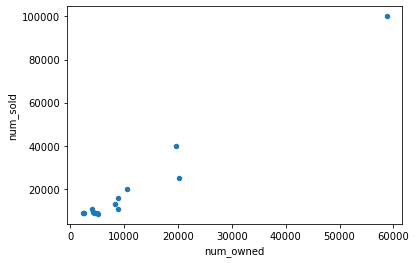

In [23]:

ax = gt_df.plot(x='num_owned', y='num_sold', kind='scatter')
ax.plot(x, np.exp(game_model.params.const + game_model.params.weight * x), color = "red")


In [89]:
y = gt_df.num_sold
X = gt_df.num_owned
X = sm.add_constant(X)

model = sm.OLS(y,X)
game_model = model.fit()

game_model.summary()

/Users/rsolava/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               num_sold   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     444.3
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           7.55e-11
Time:                        19:33:59   Log-Likelihood:                -135.34
No. Observations:                  14   AIC:                             274.7
Df Residuals:                      12   BIC:                             276.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1589.9024   1428.204      1.113      0.287   -1521.886    4701.691
num_owned      1.6422      0.078     21.078      0.000       1.472       1.812
==============================================================================
Omnibus:                        5.015   Durbin-Watson:                   2.434
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                2.290
Skew:                          -0.913   Prob(JB):                        0.318
Kurtosis:                       3.771   Cond. No.                     2.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

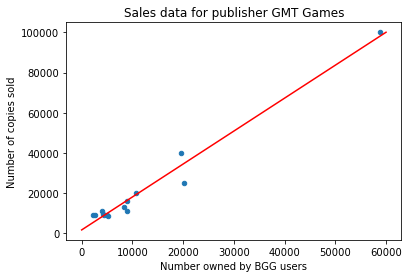

In [100]:
x = np.arange(0, 60000)

ax = gt_df.plot(x='num_owned', y='num_sold', kind='scatter')
ax.plot(x, game_model.params.const + game_model.params.num_owned * x, color = "red")

plt.title("Sales data for publisher GMT Games")
plt.ylabel("Number of copies sold")
plt.xlabel("Number owned by BGG users")

plt.savefig("owned_v_sales.png",bbox_inches="tight")


In [25]:
gt_df.num_owned.corr(gt_df.num_sold)

0.986762754618917

There is a strong linear relationship between games sold and games owned for this publisher. That's very promising for our analysis, although it may not hold as strongly for all games. It is a very small sample and not representative.

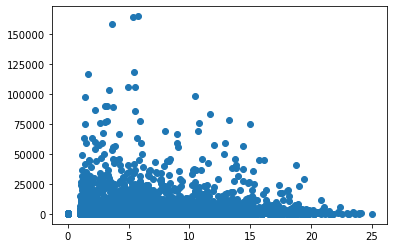

In [26]:
ax = plt.scatter(game_df.weight*game_df.weight,game_df.num_owned)

In [30]:
game_df.num_owned.corr(game_df.weight*game_df.weight)

0.08607119106869912

In [31]:
game_df.num_owned.corr(game_df.weight)

0.09418162849367459

<AxesSubplot:xlabel='num_owned', ylabel='Count'>

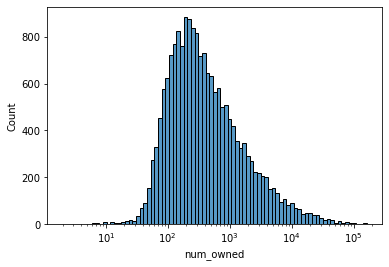

In [27]:
import seaborn as sns
sns.histplot(game_df["num_owned"], log_scale=True)

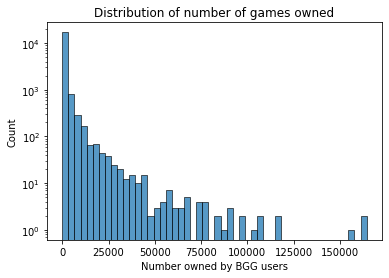

In [103]:
sns.histplot(x=game_df["num_owned"],bins=50, log_scale=(False,True))

plt.xlabel("Number owned by BGG users")

plt.title("Distribution of number of games owned")


plt.savefig("owned_dist.png",bbox_inches="tight")

<AxesSubplot:xlabel='num_owned'>

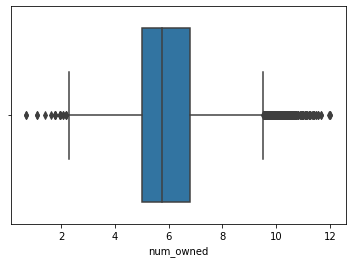

In [32]:

sns.boxplot(x=np.log(game_df["num_owned"]))

Dealing with categorical data

In [33]:
all_publishers = set(game_df.publishers.dropna().sum())
all_designers = set(game_df.designers.dropna().sum())
all_categories = set(game_df.categories.dropna().sum())
all_mechanics = set(game_df.mechanics.dropna().sum())

In [34]:
print("{} different publishers.".format(len(all_publishers)))
print("{} different designers.".format(len(all_designers)))
print("{} different categories.".format(len(all_categories)))
print("{} different mechanics.".format(len(all_mechanics)))

5148 different publishers.
8669 different designers.
83 different categories.
182 different mechanics.


In [49]:
cat_stats = {} #Key categories ,values are (count, mean owned, median owned)
for cat in all_categories:
    mask = game_df["categories"].apply(lambda x: False if x is None else cat in x)
    owned = game_df[mask].num_owned
    cat_stats[cat] = (mask.sum(), stats.gmean(owned), owned.mean(), owned.median(), owned.std())

cat_list = list(all_categories)
cat_list.sort(key=lambda x:cat_stats[x][0], reverse=True)
top10cats = cat_list[:10]
top5cats = cat_list[:5]

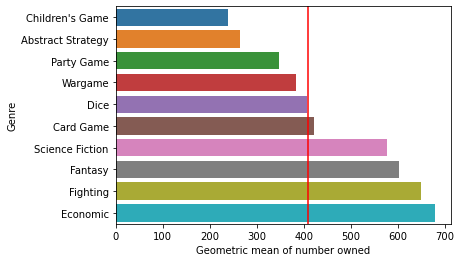

In [125]:
top10cats.sort(key=lambda x:cat_stats[x][1])
graph = sns.barplot(y= top10cats, x = [cat_stats[s][1] for s in top10cats])
graph.axvline(stats.gmean(game_df.num_owned), color = "red")

plt.ylabel("Genre")
plt.xlabel("Geometric mean of number owned")

plt.savefig("genre_owned.png",bbox_inches="tight")

In [51]:
mech_stats = {} #Key categories ,values are (count, mean owned, median owned)
for mech in all_mechanics:
    mask = game_df["mechanics"].apply(lambda x: False if x is None else mech in x)
    owned = game_df[mask].num_owned
    mech_stats[mech] = (mask.sum(), stats.gmean(owned), owned.mean(), owned.median(), owned.std())
    
mech_list = list(all_mechanics)
mech_list.sort(key=lambda x:mech_stats[x][0], reverse=True)
top10mechs = mech_list[:10]
top5mechs = mech_list[:5]

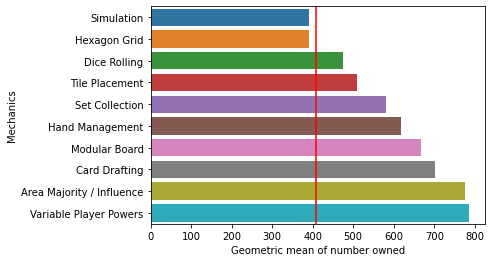

In [124]:
top10mechs.sort(key=lambda x:mech_stats[x][1])
graph = sns.barplot(y= top10mechs, x = [mech_stats[s][1] for s in top10mechs])
graph.axvline(stats.gmean(game_df.num_owned), color = "red")

plt.ylabel("Mechanics")
plt.xlabel("Geometric mean of number owned")

plt.savefig("mechs_owned.png",bbox_inches="tight")

In [57]:
pub_stats = {} #Key categories ,values are (count, mean owned, median owned)
for pub in all_publishers:
    mask = game_df["publishers"].apply(lambda x: False if x is None else pub in x)
    owned = game_df[mask].num_owned
    pub_stats[pub] = (mask.sum(), stats.gmean(owned), owned.mean(), owned.median(), owned.std())

pub_list = list(all_publishers)
pub_list.sort(key=lambda x:pub_stats[x][0], reverse=True)
top10pubs = pub_list[:10]
top5pubs = pub_list[:5]

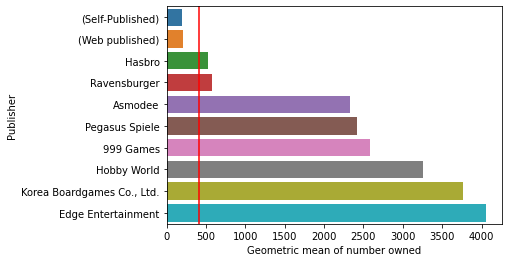

In [123]:
top10pubs.sort(key=lambda x:pub_stats[x][1])
graph = sns.barplot(y= top10pubs, x = [pub_stats[s][1] for s in top10pubs])
graph.axvline(stats.gmean(game_df.num_owned), color = "red")
plt.ylabel("Publisher")
plt.xlabel("Geometric mean of number owned")

plt.savefig("pub_owned.png",bbox_inches="tight")

Let's add those top categories/mechanics as rows to the dataframe

In [45]:
des_stats = {} #Key categories ,values are (count, mean owned, median owned)
for des in all_designers:
    mask = game_df["designers"].apply(lambda x: False if x is None else des in x)
    owned = game_df[mask].num_owned
    des_stats[des] = (mask.sum(), stats.gmean(owned), owned.mean(), owned.median(), owned.std())

des_list = list(all_designers)
des_list.sort(key=lambda x:des_stats[x][0], reverse=True)
top10dess = des_list[:10]

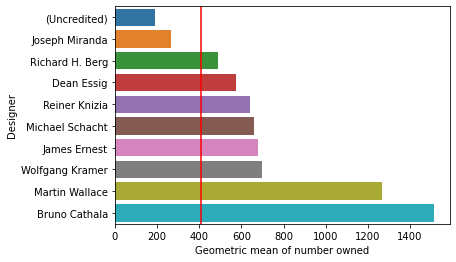

In [122]:
top10dess.sort(key=lambda x:des_stats[x][1])
graph = sns.barplot(y= top10dess, x = [des_stats[s][1] for s in top10dess])
graph.axvline(stats.gmean(game_df.num_owned), color = "red")

plt.ylabel("Designer")
plt.xlabel("Geometric mean of number owned")

plt.savefig("designer_owned.png",bbox_inches="tight")

Add rows for the top 5 most common categories, mechanics, and publishers, as well as Uncredited in the designer feature.

In [58]:
for cat in top5cats:
    game_df[cat] = game_df.categories.apply(lambda x: 0 if x is None or cat not in x else 1)

for mech in top5mechs:
    game_df[mech] = game_df.mechanics.apply(lambda x: 0 if x is None or mech not in x else 1)
    
for pub in top5pubs:
    game_df[pub] = game_df.publishers.apply(lambda x: 0 if x is None or pub not in x else 1)

game_df["(Uncredited)"] = game_df.designers.apply(lambda x: 0 if x is None or "(Uncredited)" not in x else 1)

In [59]:
game_df.shape

(18678, 32)

In [116]:
X =game_df.drop(columns =["name","url","num_owned","designers","publishers","categories","mechanics","log_owned"])
#X["weight_sq"] = X.weight*X.weight
#X = X.drop(columns="weight")
X["avg_time"] = (X.min_time + X.max_time)/2
X = X.drop(columns=["min_time","max_time"])
X["avg_players"] = (X.min_players + X.max_players)/2
X = X.drop(columns=["min_players","max_players"])
y = game_df.log_owned
X = sm.add_constant(X)

X, X_test, y, y_test = train_test_split(X,y, test_size=0.3)

model = sm.OLS(y,X)
game_model = model.fit()

game_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_owned   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     234.7
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:28:04   Log-Likelihood:                -9705.9
No. Observations:               13074   AIC:                         1.946e+04
Df Residuals:                   13051   BIC:                         1.963e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10.8735      1.064     10.223      0.000       8.789      12.958
year                      -0.0049      0.001     -9.199      0.000      -0.006      -0.004
rating                     0.1913      0.007     29.359      0.000       0.179       0.204
weight                     0.0965      0.008     12.362      0.000       0.081       0.112
player_age                 0.0147      0.002      7.707      0.000       0.011       0.018
Card Game                  0.0064      0.011      0.563      0.574      -0.016       0.029
Wargame                   -0.2414      0.018    -13.515      0.000      -0.276      -0.206
Fantasy                    0.0470      0.014      3.339      0.001       0.019       0.075
Party Game                 0.0446      0.016      2.703      0.007       0.012       0.077
Dice                       0.0452      0.018      2.453      0.014       0.009       0.081
Dice Rolling               0.0639      0.013      5.037      0.000       0.039       0.089
Hand Management            0.1720      0.012     14.039      0.000       0.148       0.196
Set Collection             0.1607      0.013     11.993      0.000       0.134       0.187
Variable Player Powers     0.1330      0.015      9.050      0.000       0.104       0.162
Hexagon Grid              -0.0289      0.020     -1.455      0.146      -0.068       0.010
Asmodee                    0.6439      0.028     23.388      0.000       0.590       0.698
Hasbro                     0.3918      0.028     13.893      0.000       0.337       0.447
(Self-Published)          -0.3214      0.028    -11.297      0.000      -0.377      -0.266
(Web published)           -0.2864      0.029    -10.000      0.000      -0.343      -0.230
999 Games                  0.7108      0.030     23.650      0.000       0.652       0.770
(Uncredited)              -0.1530      0.020     -7.485      0.000      -0.193      -0.113
avg_time               -7.688e-06   2.62e-05     -0.294      0.769    -5.9e-05    4.36e-05
avg_players                0.0006      0.001      0.969      0.333      -0.001       0.002
==============================================================================
Omnibus:                      294.368   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              358.879
Skew:                           0.306   Prob(JB):                     1.18e-78
Kurtosis:                       3.533   Cond. No.                     4.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

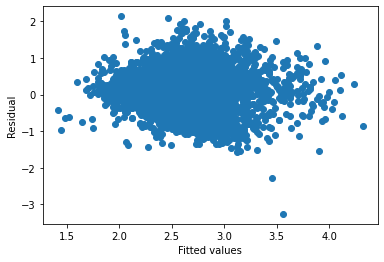

In [126]:
y_pred = game_model.predict(X_test)
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)

plt.xlabel("Fitted values")
plt.ylabel("Residual")


plt.savefig("heteroskadicity.png",bbox_inches="tight")

<AxesSubplot:xlabel='year', ylabel='num_owned'>

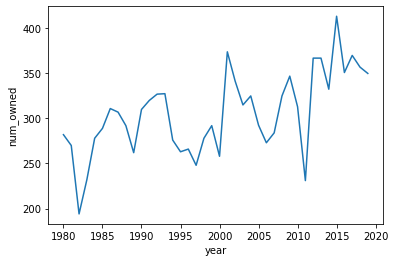

In [45]:
vals = game_df.sort_values(by="year").groupby(by="year").num_owned.median()
sns.lineplot(x = vals.index, y = vals)

In [46]:
#game_df[game_df.year==1630]

In [75]:
y = game_df.log_owned
X = game_df.drop(columns =["name","url","num_owned","designers",
                           "publishers","categories","mechanics","log_owned"])

X, X_test, y, y_test = train_test_split(X,y, test_size=0.3)

reg_tree = RandomForestRegressor(max_depth=100,n_estimators = 100,max_features=None)
reg_tree.fit(X, y)

RandomForestRegressor(max_depth=100, max_features=None)

In [76]:
reg_tree.score(X_test,y_test)

0.4588581819552201

In [66]:
y_pred = reg_tree.predict(X_test)
residuals = y_test - y_pred

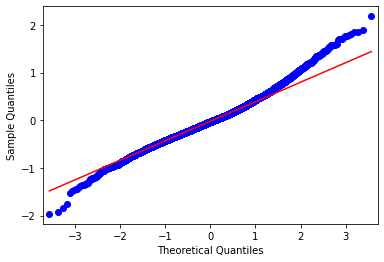

In [67]:
from statsmodels.graphics.gofplots import qqplot

qp = qqplot(residuals, line = 'q')

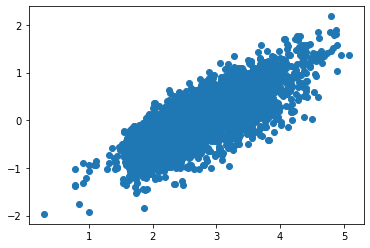

In [68]:
plt.scatter(y_test, residuals)

In [69]:
reg_tree.feature_importances_

array([0.12291669, 0.3271045 , 0.07028551, 0.03147653, 0.06578217,
       0.05760102, 0.06876673, 0.01641372, 0.01011061, 0.01444497,
       0.00755012, 0.01005713, 0.01559797, 0.01848169, 0.01703609,
       0.02012112, 0.00883316, 0.04612147, 0.00721124, 0.00823228,
       0.00772112, 0.04071279, 0.00742138])

In [71]:
from sklearn.inspection import permutation_importance

result = permutation_importance(reg_tree, X, y, n_repeats=10)

In [72]:
result

{'importances_mean': array([0.29384146, 0.92076188, 0.17256168, 0.05408161, 0.14973852,
        0.14109201, 0.24018507, 0.02888382, 0.0498965 , 0.02660935,
        0.01618004, 0.01525439, 0.03857762, 0.16883147, 0.06217166,
        0.13005699, 0.01919834, 0.10534696, 0.01745561, 0.01256313,
        0.01091112, 0.10475558, 0.02156174]),
 'importances_std': array([0.0038007 , 0.0073547 , 0.00255616, 0.0008331 , 0.00162216,
        0.00222762, 0.00385062, 0.00049023, 0.0016332 , 0.00089466,
        0.00045416, 0.00030033, 0.00083289, 0.0023574 , 0.00161652,
        0.00269667, 0.00121799, 0.00355438, 0.00071259, 0.00108956,
        0.00052197, 0.00216156, 0.0006232 ]),
 'importances': array([[0.28769582, 0.29042561, 0.29508048, 0.29807504, 0.29392092,
         0.29312764, 0.29046383, 0.29142334, 0.29799147, 0.30021044],
        [0.91822937, 0.92955599, 0.93416532, 0.92624608, 0.9172388 ,
         0.91010474, 0.91056086, 0.92114543, 0.92306527, 0.91730693],
        [0.1688157 , 0.16850125,

In [70]:
X.columns

Index(['year', 'weight', 'player_age', 'min_players', 'max_players',
       'min_time', 'max_time', 'Card Game', 'Wargame', 'Fantasy', 'Party Game',
       'Dice', 'Dice Rolling', 'Hand Management', 'Set Collection',
       'Variable Player Powers', 'Hexagon Grid', 'Asmodee', 'Hasbro',
       '(Self-Published)', '(Web published)', '999 Games', '(Uncredited)'],
      dtype='object')

In [132]:
lr = LinearRegression()

lr.fit(X, np.log10(y))
y_pred = lr.predict(X_test)

In [133]:
residuals = np.log10(y_test) - y_pred

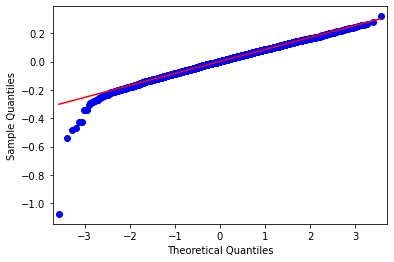

In [134]:
from statsmodels.graphics.gofplots import qqplot

qp = qqplot(residuals, line = 'q')

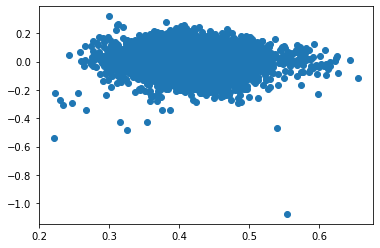

In [136]:
plt.scatter(y_pred, residuals)

In [128]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

lr = HuberRegressor()

lr.fit(X_scaled, np.log10(y))
y_pred = lr.predict(scaler.transform(X_test))

In [129]:
residuals = np.log10(y_test) - y_pred

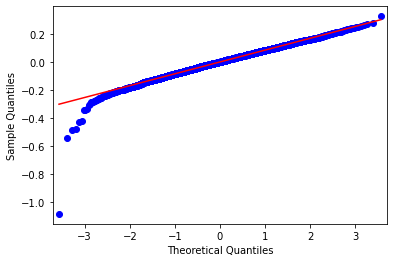

In [130]:
qp = qqplot(residuals, line = 'q')

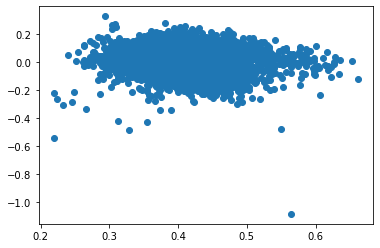

In [131]:
plt.scatter(y_pred, residuals)